# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

<ipython-input-22-a4ecdd2bc52f>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## GPU 설정

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d .

--2023-08-14 06:43:13--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.150.53, 54.192.150.31, 54.192.150.27, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.150.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  62.7MB/s    in 0.7s    

2023-08-14 06:43:14 (62.7 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: ./hymenoptera_data/
   creating: ./hymenoptera_data/train/
   creating: ./hymenoptera_data/train/ants/
  inflating: ./hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: .

## 전처리 설정

In [11]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                  'val': transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                  }

In [12]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             shuffle=True,
                             num_workers=4) for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [14]:
model_ft = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 330MB/s]


- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [17]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

-

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [19]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2) # 클래스 2개로 변경

model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [23]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [24]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 모델 학습

- 학습 함수 정의

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch:{}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train', 'val']:
      if phase=='train':
        model.train()
      else:
        model.eval()

      running_loss=0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels) # torch.nn.CrossEntropyLoss()는 알아서 계산 torch.max없이

          if phase=='train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data)

      if phase=='train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase=='val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_moedl_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training time : {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best Validation Acc:{:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [48]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch:0/24
----------
train loss: 0.4037	Accuracy: 0.8525
val loss: 1.0510	Accuracy: 0.7582

Epoch:1/24
----------
train loss: 0.4051	Accuracy: 0.8320
val loss: 0.9925	Accuracy: 0.7582

Epoch:2/24
----------
train loss: 0.4616	Accuracy: 0.8074
val loss: 1.2080	Accuracy: 0.7516

Epoch:3/24
----------
train loss: 0.4142	Accuracy: 0.8361
val loss: 1.9785	Accuracy: 0.7059

Epoch:4/24
----------
train loss: 0.3884	Accuracy: 0.8770
val loss: 0.7607	Accuracy: 0.7582

Epoch:5/24
----------
train loss: 0.4363	Accuracy: 0.8156
val loss: 0.7366	Accuracy: 0.7843

Epoch:6/24
----------
train loss: 0.3663	Accuracy: 0.8607
val loss: 1.0884	Accuracy: 0.7516

Epoch:7/24
----------
train loss: 0.4342	Accuracy: 0.8156
val loss: 2.1769	Accuracy: 0.7124

Epoch:8/24
----------
train loss: 0.4274	Accuracy: 0.8197
val loss: 0.8841	Accuracy: 0.7516

Epoch:9/24
----------
train loss: 0.4308	Accuracy: 0.8115
val loss: 1.3728	Accuracy: 0.7320

Epoch:10/24
----------
train loss: 0.4166	Accuracy: 0.8197
val loss: 1

## 결과 시각화

- 시각화 함수 정의

In [49]:
def imshow(img):
  img = img/2+0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [56]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return

    model.train(mode=was_training)

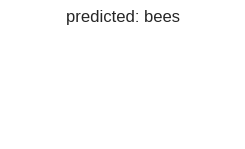

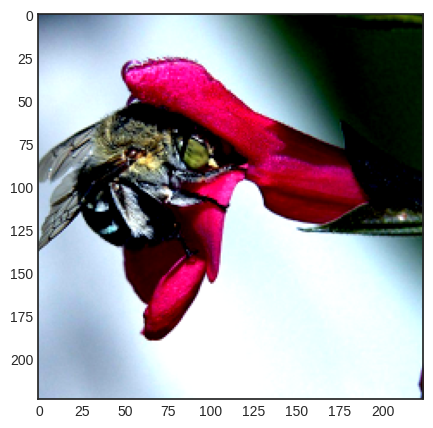

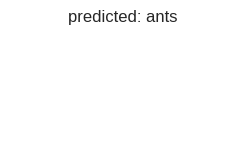

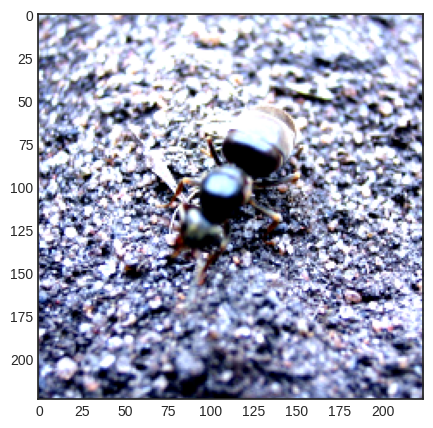

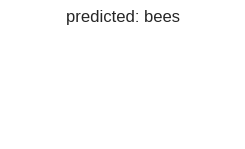

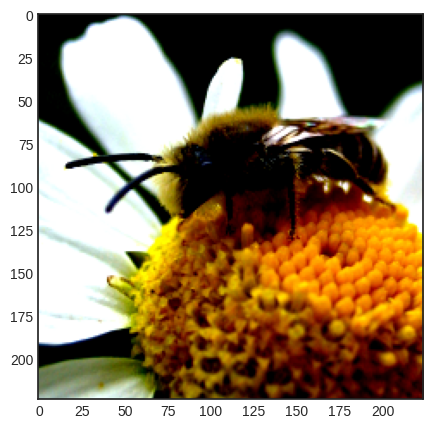

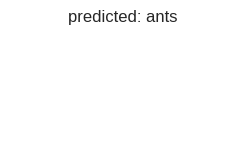

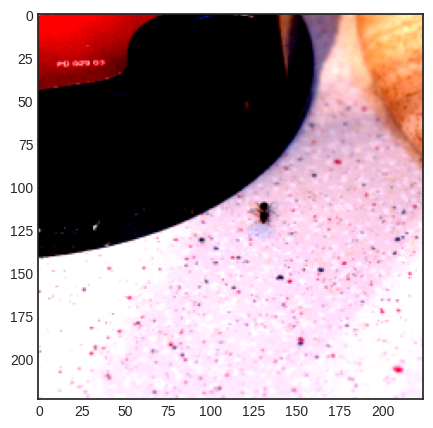

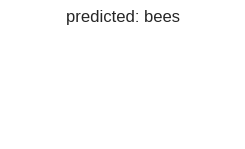

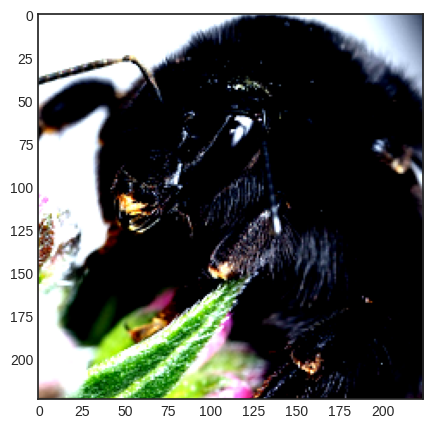

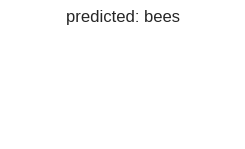

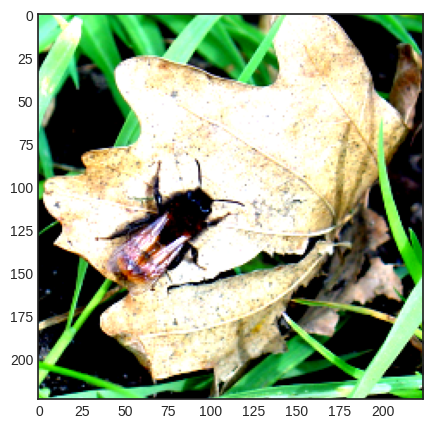

In [57]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [60]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)



In [61]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch:0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train loss: 1.3167	Accuracy: 0.5123
val loss: 1.4863	Accuracy: 0.5425

Epoch:1/24
----------
train loss: 1.5369	Accuracy: 0.4467
val loss: 1.4868	Accuracy: 0.4575

Epoch:2/24
----------
train loss: 1.3617	Accuracy: 0.4918
val loss: 0.6698	Accuracy: 0.6209

Epoch:3/24
----------
train loss: 1.1868	Accuracy: 0.5041
val loss: 0.9791	Accuracy: 0.5359

Epoch:4/24
----------
train loss: 1.3441	Accuracy: 0.4959
val loss: 0.5390	Accuracy: 0.7386

Epoch:5/24
----------
train loss: 1.6308	Accuracy: 0.5082
val loss: 0.5576	Accuracy: 0.6928

Epoch:6/24
----------
train loss: 1.2909	Accuracy: 0.5041
val loss: 2.7450	Accuracy: 0.4575

Epoch:7/24
----------
train loss: 0.8495	Accuracy: 0.5410
val loss: 0.4894	Accuracy: 0.7778

Epoch:8/24
----------
train loss: 0.7012	Accuracy: 0.5451
val loss: 0.6765	Accuracy: 0.6863

Epoch:9/24
----------
train loss: 0.7481	Accuracy: 0.5205
val loss: 0.4714	Accuracy: 0.7778

Epoch:10/24
----------
train loss: 0.7362	Accuracy: 0.5164
val loss: 0.4998	Accuracy: 0.7516

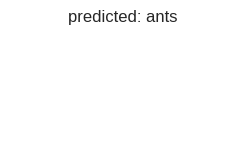

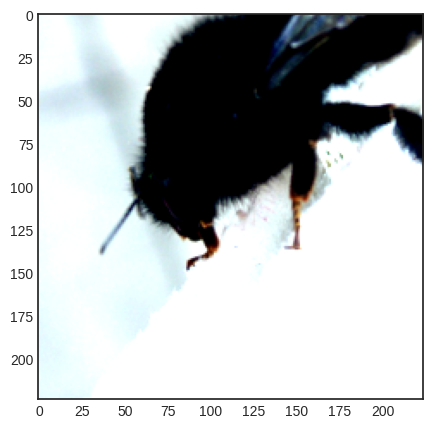

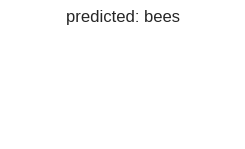

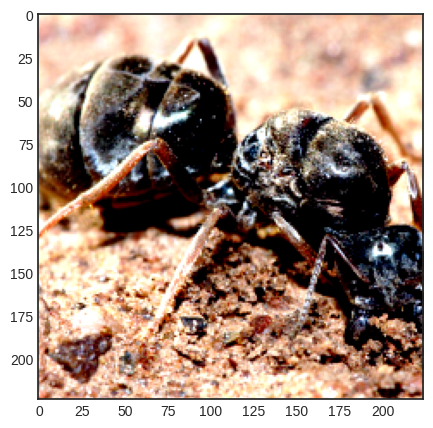

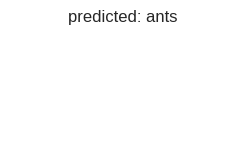

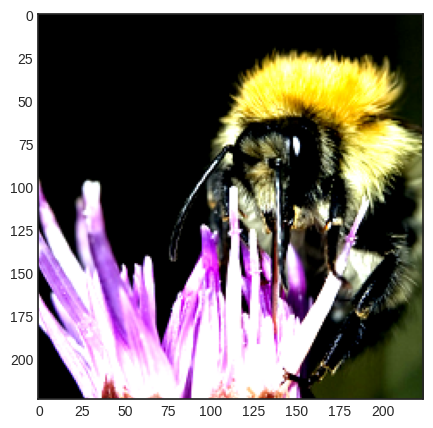

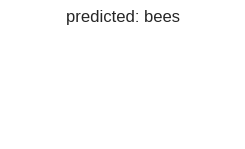

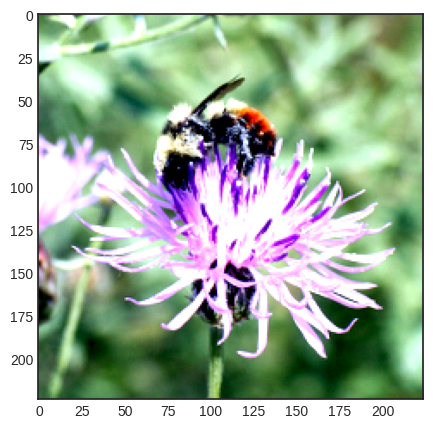

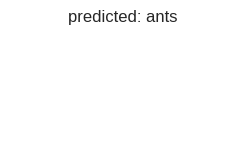

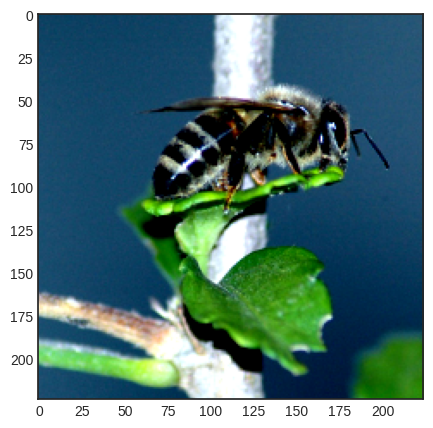

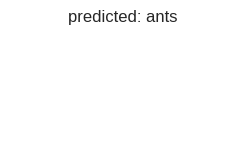

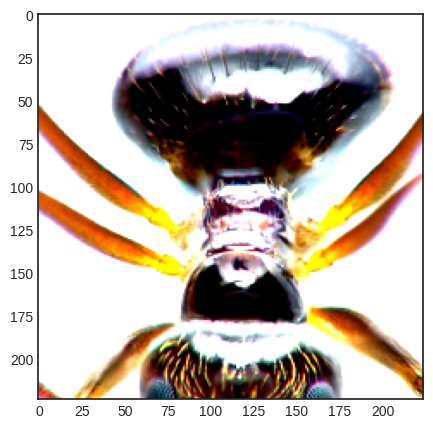

In [62]:
visualize_model(model_conv)